In [1]:
!pip install timm
!pip install opendatasets

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import opendatasets
from tqdm.notebook import tqdm

In [95]:
#Step1: PyTorch Dataset(and Dataloader)
class PlayingCardDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data = ImageFolder(data_dir, transform=transform)


  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

  @property
  def classes(self):
    return self.data.classes

In [96]:
opendatasets.download("https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification")

Skipping, found downloaded files in "./cards-image-datasetclassification" (use force=True to force download)


In [97]:
data_dir = './cards-image-datasetclassification/train'
dataset = PlayingCardDataset(
    data_dir = data_dir
)

In [98]:
image, label = dataset[4444]
label

30

In [99]:
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [100]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])
dataset = PlayingCardDataset(data_dir,transform)

In [101]:
dataset[100]

(tensor([[[0.0000, 0.0039, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0078, 0.0431,  ..., 0.0196, 0.0039, 0.0078],
          [0.0235, 0.0392, 0.3490,  ..., 0.2392, 0.0314, 0.0118],
          ...,
          [0.0039, 0.0235, 0.2392,  ..., 0.2196, 0.0314, 0.0118],
          [0.0039, 0.0039, 0.0235,  ..., 0.0118, 0.0078, 0.0039],
          [0.0039, 0.0078, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],
 
         [[0.0078, 0.0078, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0392,  ..., 0.0196, 0.0039, 0.0078],
          [0.0078, 0.0275, 0.3373,  ..., 0.2392, 0.0275, 0.0078],
          ...,
          [0.0039, 0.0235, 0.2431,  ..., 0.2196, 0.0314, 0.0078],
          [0.0039, 0.0039, 0.0235,  ..., 0.0157, 0.0078, 0.0039],
          [0.0039, 0.0078, 0.0039,  ..., 0.0078, 0.0078, 0.0039]],
 
         [[0.0196, 0.0196, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
          [0.0118, 0.0078, 0.0353,  ..., 0.0157, 0.0039, 0.0078],
          [0.0118, 0.0196, 0.3137,  ...,

In [102]:
image, label = dataset[100]

In [103]:
image.shape

torch.Size([3, 128, 128])

In [104]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [105]:
for images, labels in dataloader:
  break

In [106]:
images.shape

torch.Size([32, 3, 128, 128])

In [107]:
#Creating PyTorch Model
class SimpleCardClassifier(nn.Module):
  def __init__(self, num_classes = 53):
    super(SimpleCardClassifier, self).__init__()
    self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
    self.features = nn.Sequential(*list(self.base_model.children())[:-1])
    enet_out_size = 1280
    #making a classifier
    self.classifier = nn.Linear(enet_out_size, num_classes)

  def forward(self, x):
    x = self.features(x)
    output = self.classifier(x)
    return output

In [108]:
model = SimpleCardClassifier(num_classes=53)

In [109]:
example_output = model(images)
example_output.shape

torch.Size([32, 53])

In [110]:
#loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [111]:
criterion(example_output, labels)

tensor(3.9683, grad_fn=<NllLossBackward0>)

In [112]:
train_folder = './cards-image-datasetclassification/train/'
valid_folder = './cards-image-datasetclassification/valid/'
test_folder = './cards-image-datasetclassification/test/'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [113]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [114]:
num_epoch = 5
train_losses, val_losses = [], []
model.to(device)
for epoch in range(num_epoch):
  #set the model to train
  model.train()
  running_loss = 0.0
  for images, labels in tqdm(train_loader, desc = 'Training Loop'):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * labels.size(0)
  train_loss = running_loss / len(train_loader.dataset)
  train_losses.append(train_loss)
  #validation
  model.eval()
  running_loss = 0.0
  with torch.no_grad():
    for images, labels in tqdm(val_loader, desc = 'Validation Loop'):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

  print(f"Epoch {epoch+1}/{num_epoch} - Training loss : {train_loss} - Valid loss : {val_loss}")

Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Training loss : 1.5749458442329736 - Valid loss : 0.40053215705842343


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Training loss : 0.5638370563951394 - Valid loss : 0.27052886136280335


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Training loss : 0.3669777697993976 - Valid loss : 0.3040759082251


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Training loss : 0.2546217215852372 - Valid loss : 0.14492984844266243


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Training loss : 0.1901550780891872 - Valid loss : 0.21290264781915916


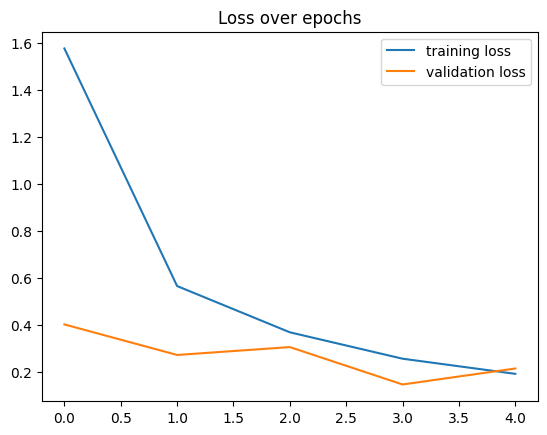

In [115]:
#Visualize loss
plt.plot(train_losses, label="training loss")
plt.plot(val_losses, label="validation loss")
plt.legend()
plt.title('Loss over epochs')
plt.show()

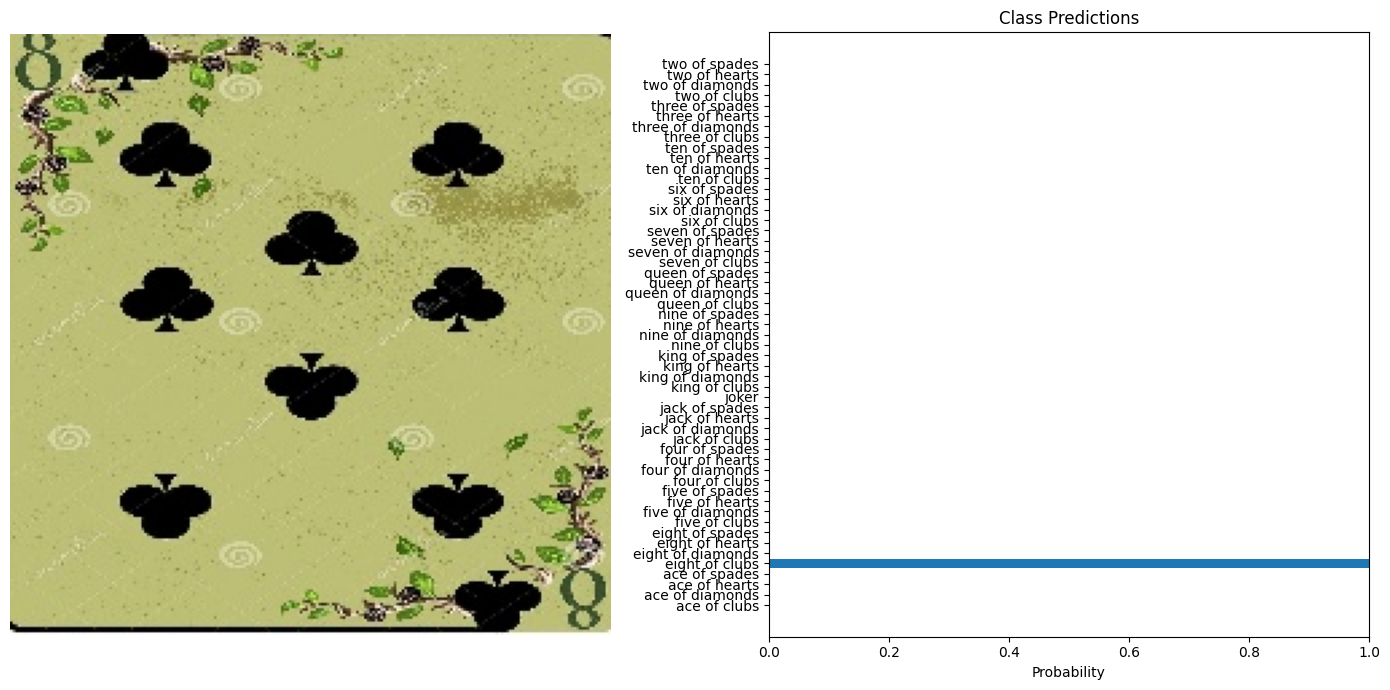

In [116]:
#Evaluate Result
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "cards-image-datasetclassification/test/eight of clubs/4.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)

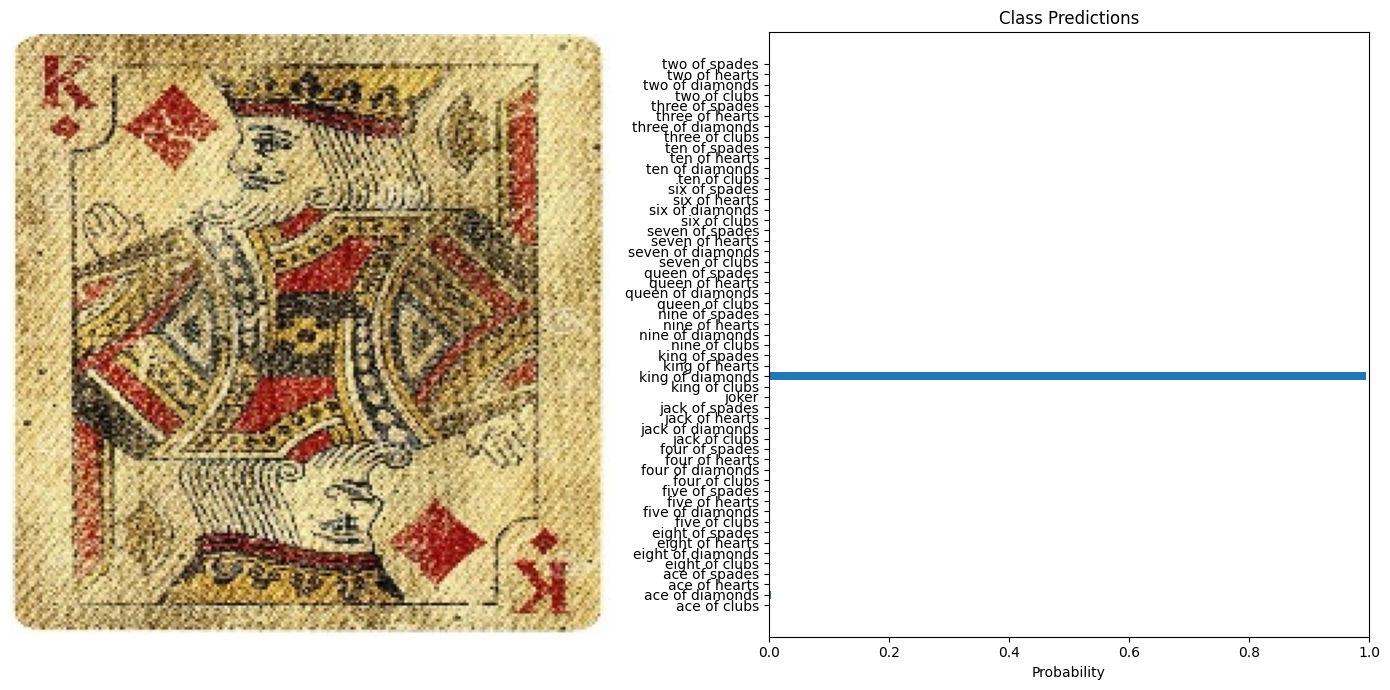

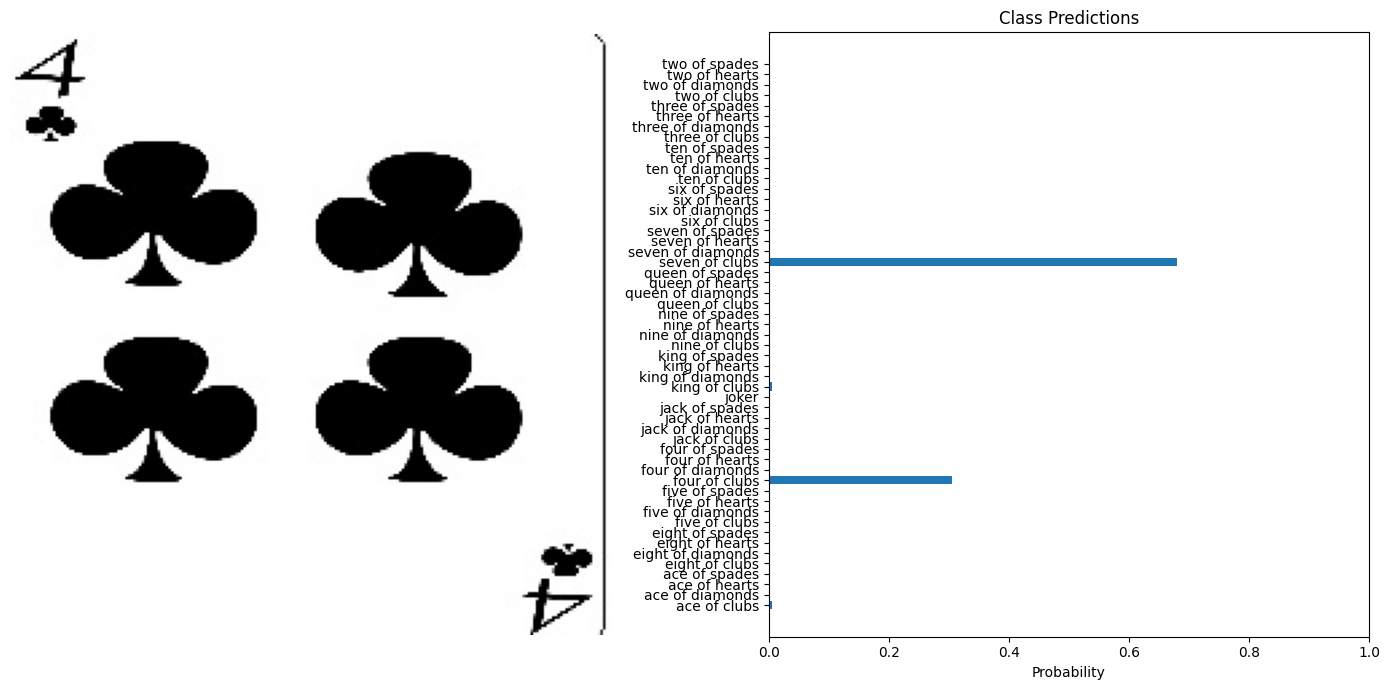

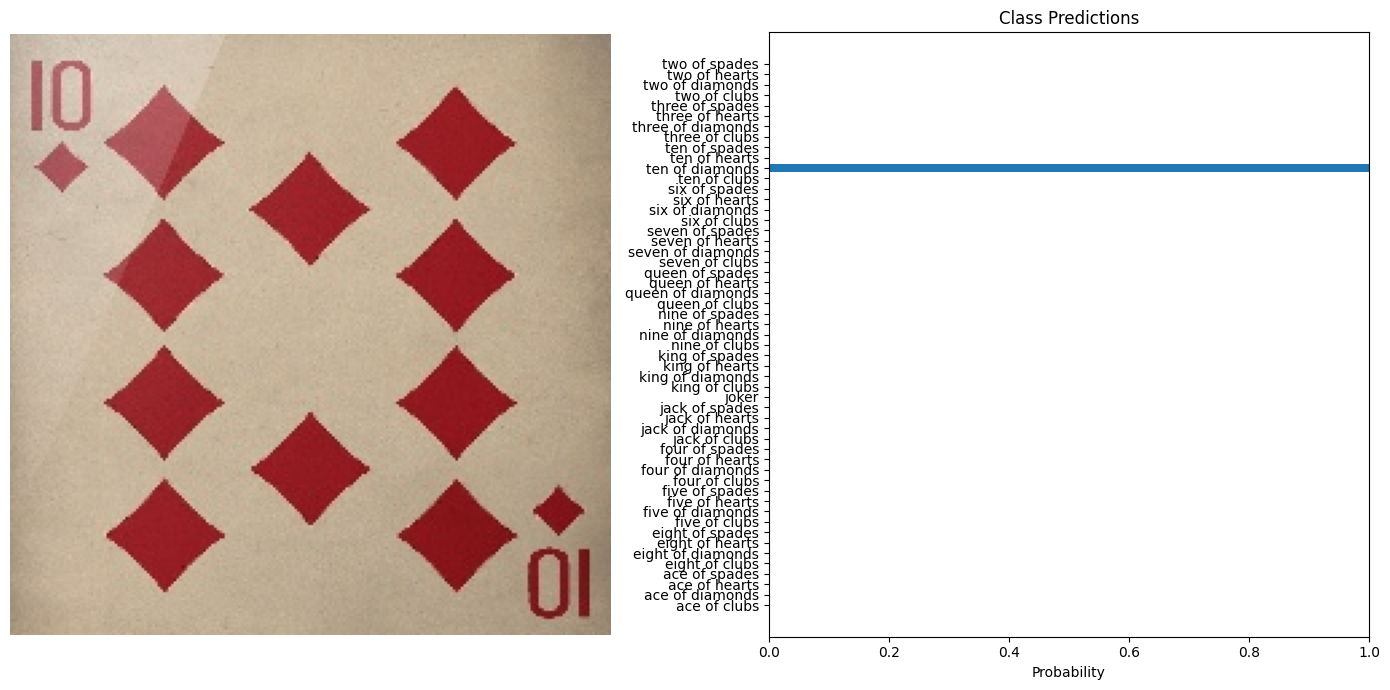

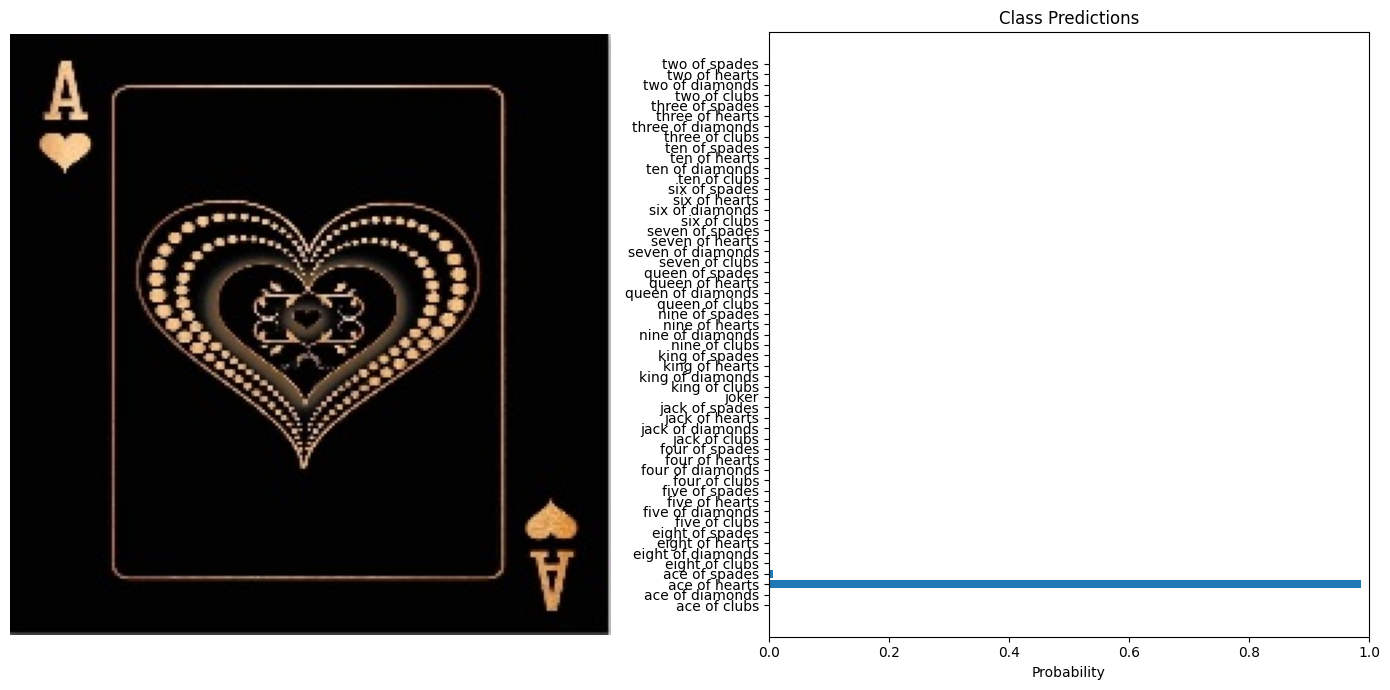

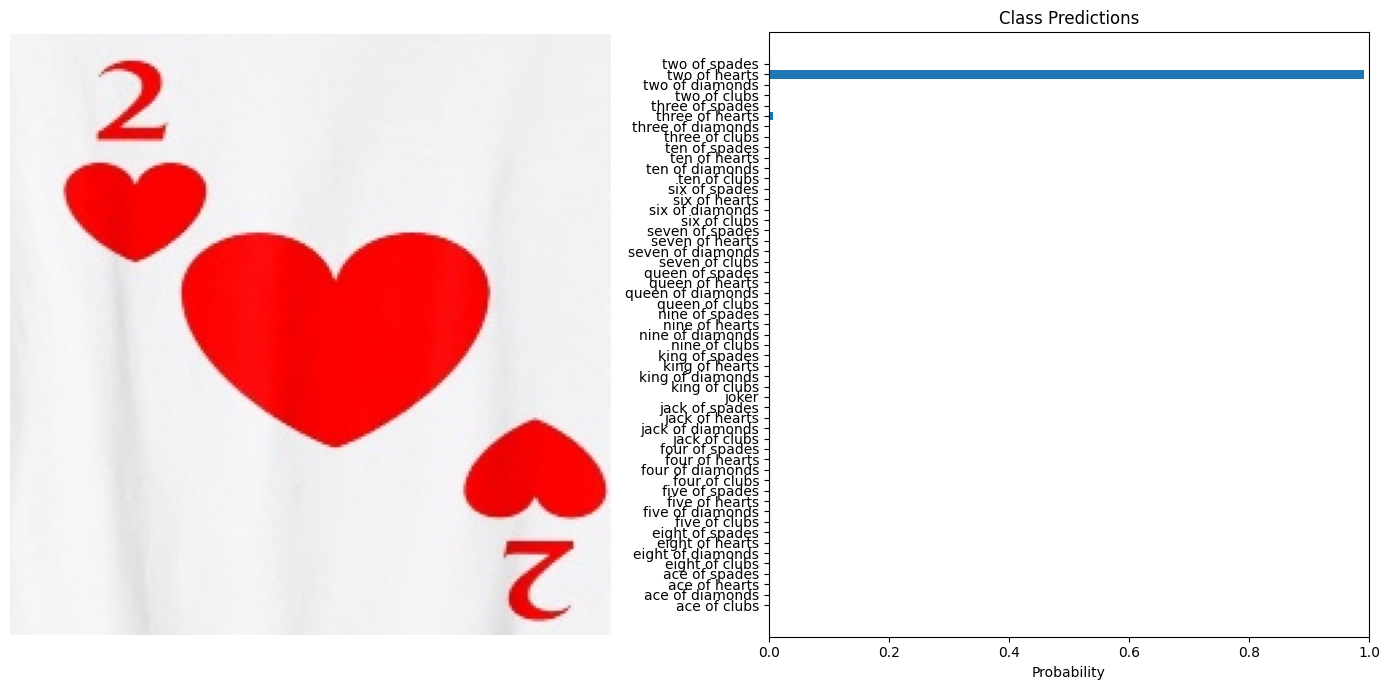

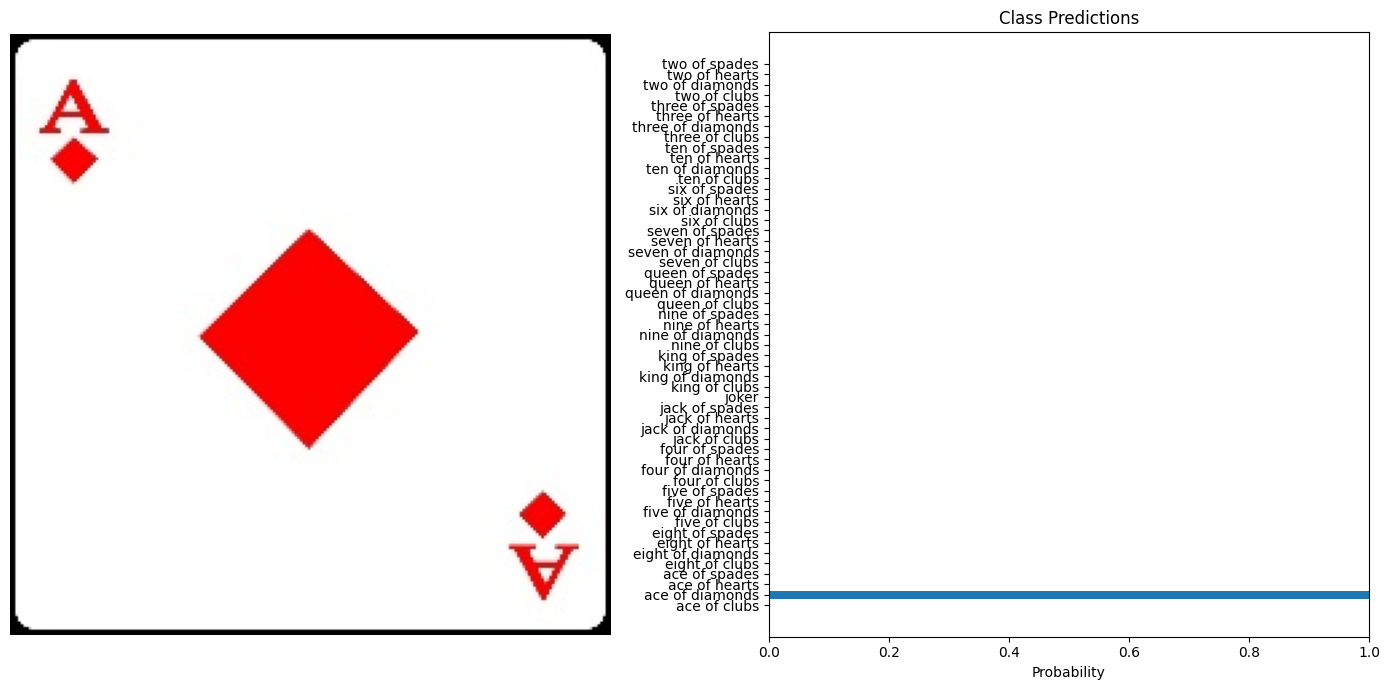

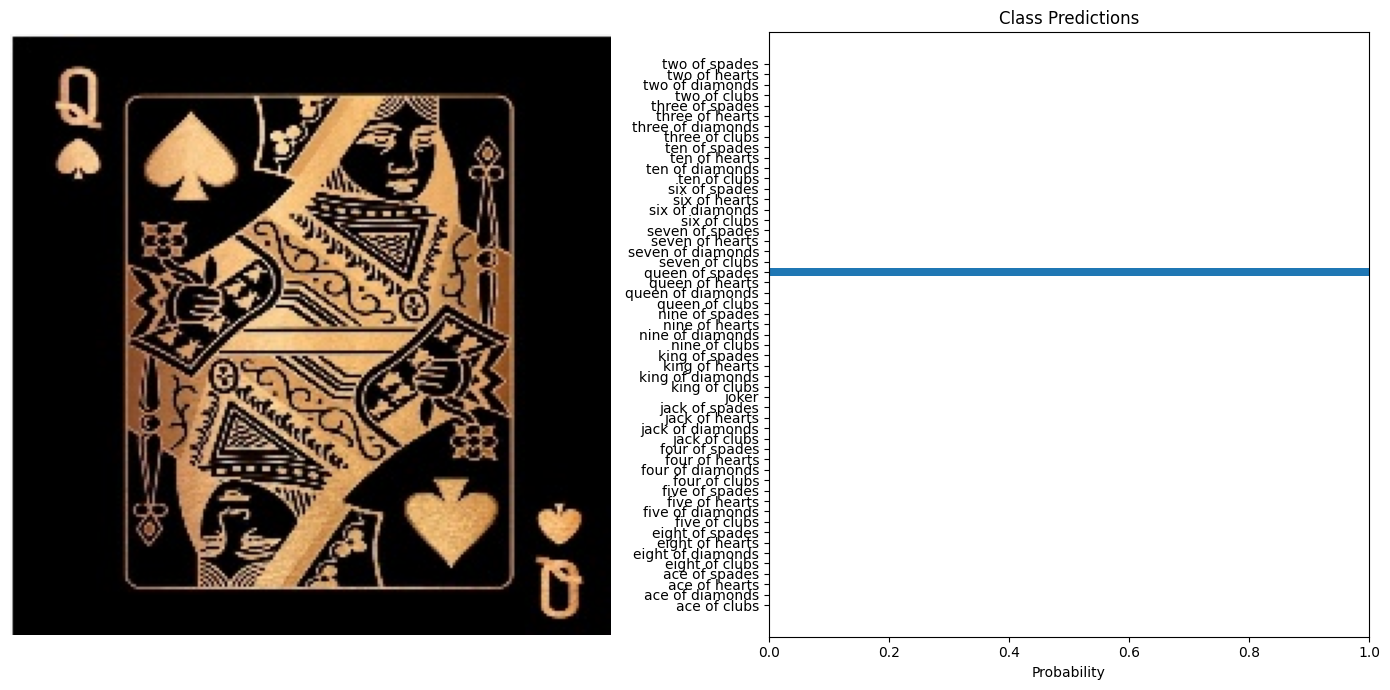

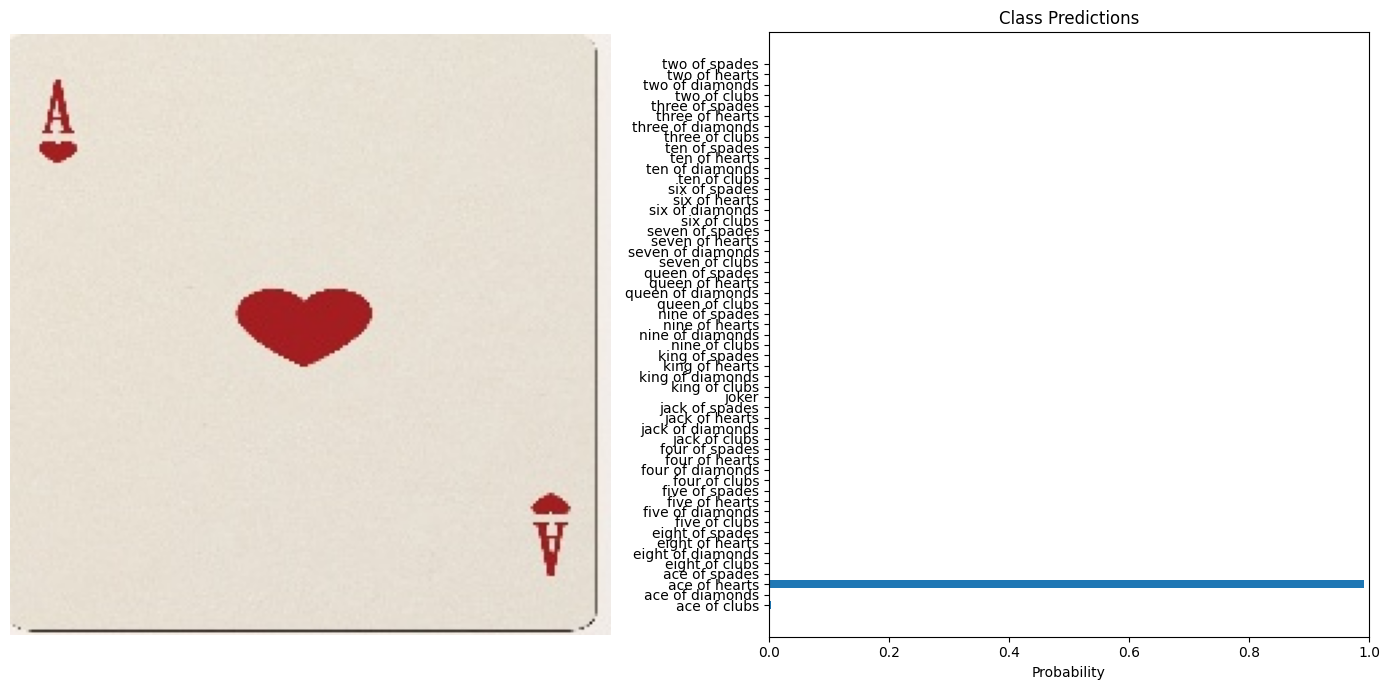

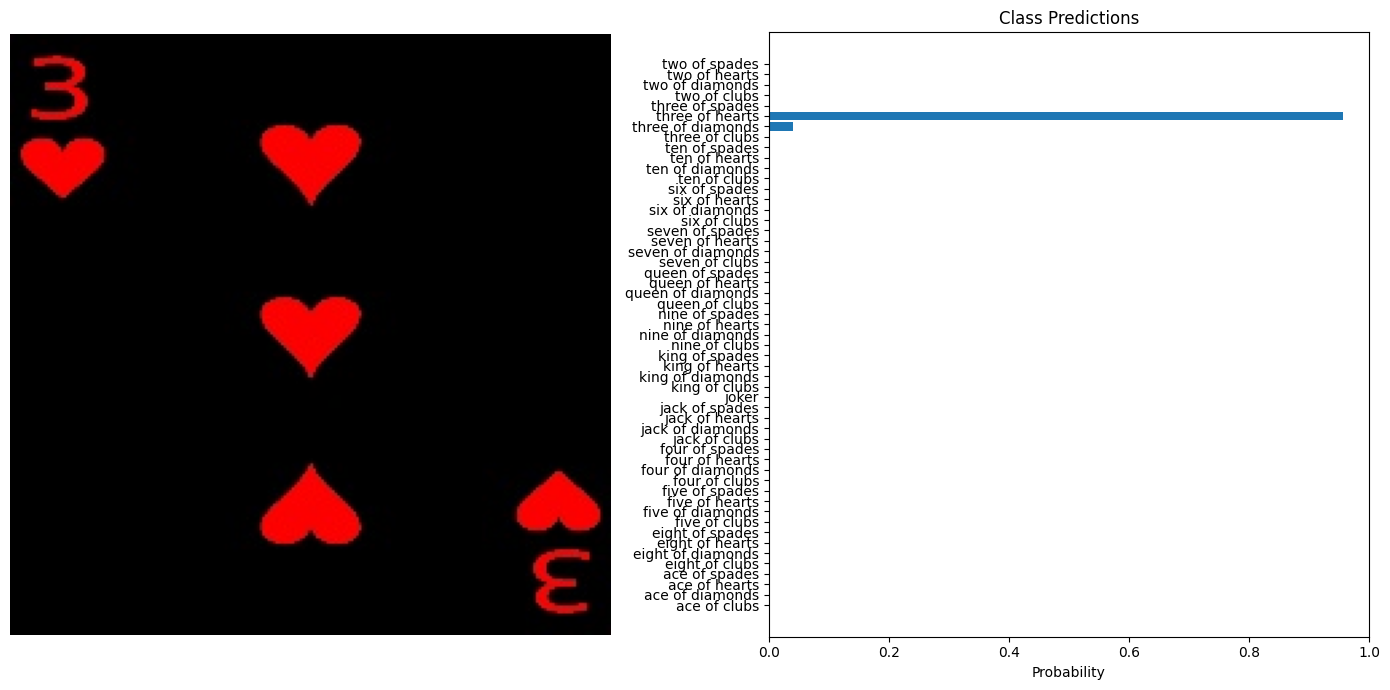

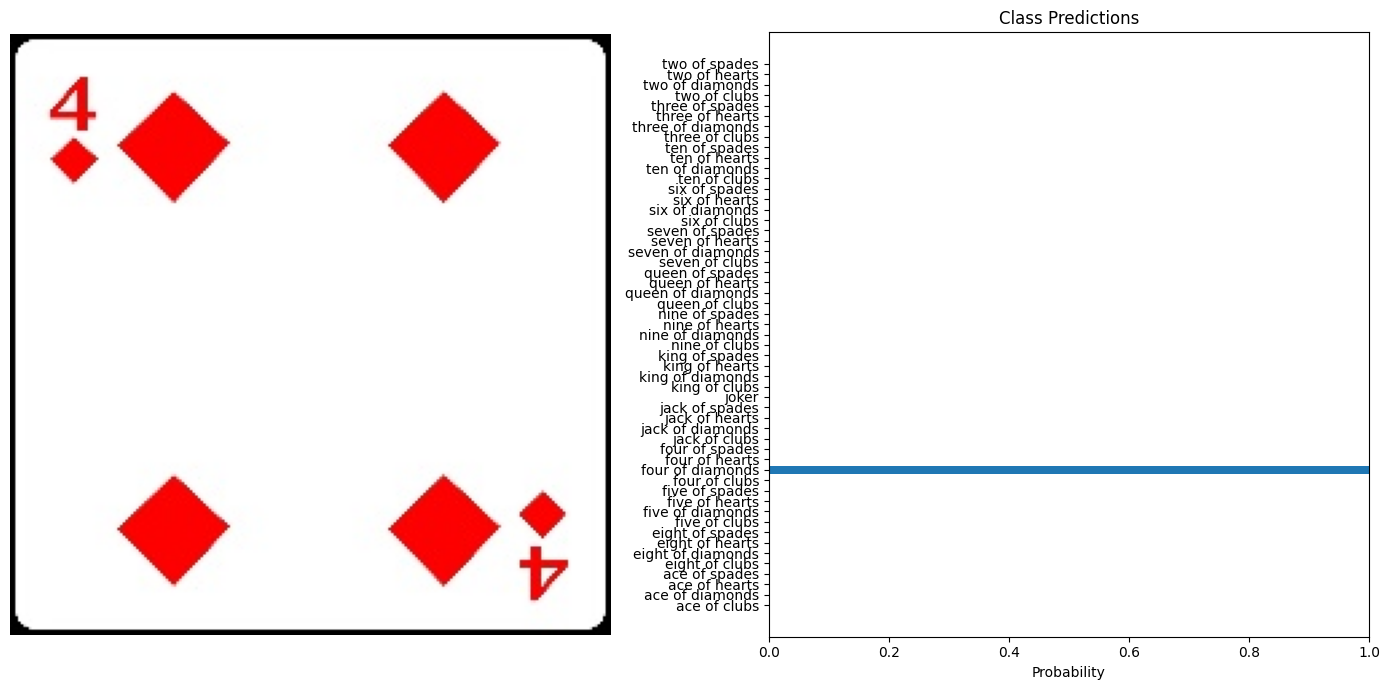

In [117]:
from glob import glob
test_images = glob('./cards-image-datasetclassification/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes
    visualize_predictions(original_image, probabilities, class_names)